# JANATA HACK
Credit Card payment default prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

train_ = pd.read_csv('/home/aakash/janta_hack/train_janta.csv') 
test_ = pd.read_csv('/home/aakash/janta_hack/test_janta.csv')
print(train_.shape) ## 20 data columns. 10000 data points.
print(test_.shape) #  data points,

(21000, 25)
(9000, 24)


In [2]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import pandas_profiling
train_.profile_report() ## Default payment next month is our target variable.
## Binary Classification problem.

In [2]:
## Missing Values.
train_.isna().sum() ## No missing values as such!

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default_payment_next_month    0
dtype: int64

In [4]:
test_.profile_report()

In [3]:
test_.isna().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [4]:
y = train_['default_payment_next_month'].astype(int)
print(y.value_counts())
test_id = test_['ID']

## Concatenating the datasets so that we can do simultaneous preprocessing.
data = pd.concat([train_, test_],  axis = 0, ignore_index = False)
data = data.drop(['ID', 'default_payment_next_month'], axis=1)
data.shape

0    16355
1     4645
Name: default_payment_next_month, dtype: int64


(30000, 23)

# Normalizing the Features

In [5]:
from scipy.stats import boxcox, skew

skew_feat = data.apply(lambda x: skew(x.dropna()))
skew_feat = skew_feat[(skew_feat > 1.1)]
skew_feat = skew_feat.index

# Using box-cox transformations for normalisation.
def normalizing(X):
    data[X][data[X] < 0] = 0
    data[X][data[X] > data[X].quantile(0.99)] = data[X].quantile(0.99)
    data[X] = data[X].apply(lambda x: x+np.random.rand())
    data[X] = data[X].apply(lambda x: x+1)
    data[X], _ = boxcox(data[X])

for i in skew_feat:
    normalizing(i)

In [6]:
# Let's then put 85% of our dataset into a training set and 15% of it into a test set. 
# We can use random_state because it is not a time series dataset that we are using.
train = data[:train_.shape[0]]
test = data[train_.shape[0]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, 
                                                    test_size=0.15, random_state=20, stratify=y)

# LightGBM Classifier

In [7]:
## LightGBM Classifier.
# Modelling
## Adding an Light GBM model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def lgb_auc_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return('AUC_Score', roc_auc_score(y_true, y_hat), True)

In [8]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
       "objective" : "binary",
       "n_estimators":10000,
       "reg_alpha" : 2.0,
       "reg_lambda":2.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":0.8,
       "subsample":0.8715623,
       "min_data_in_leaf":20,
       "nthread":4,
       "metric" : "auc",
       "num_leaves" : 100,
       "learning_rate" : 0.0115555,
       "verbosity" : -1,
       "seed": 12,
       "max_bin":60,
       'max_depth':15,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,
                      feval=lgb_auc_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return(pred_test_y, model, evals_result)

In [9]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.846688	training's AUC_Score: 0.617622	valid_1's auc: 0.769722	valid_1's AUC_Score: 0.608906
[200]	training's auc: 0.868248	training's AUC_Score: 0.675234	valid_1's auc: 0.770852	valid_1's AUC_Score: 0.650772
Early stopping, best iteration is:
[176]	training's auc: 0.862832	training's AUC_Score: 0.668301	valid_1's auc: 0.771062	valid_1's AUC_Score: 0.647283
LightGBM Training Completed...


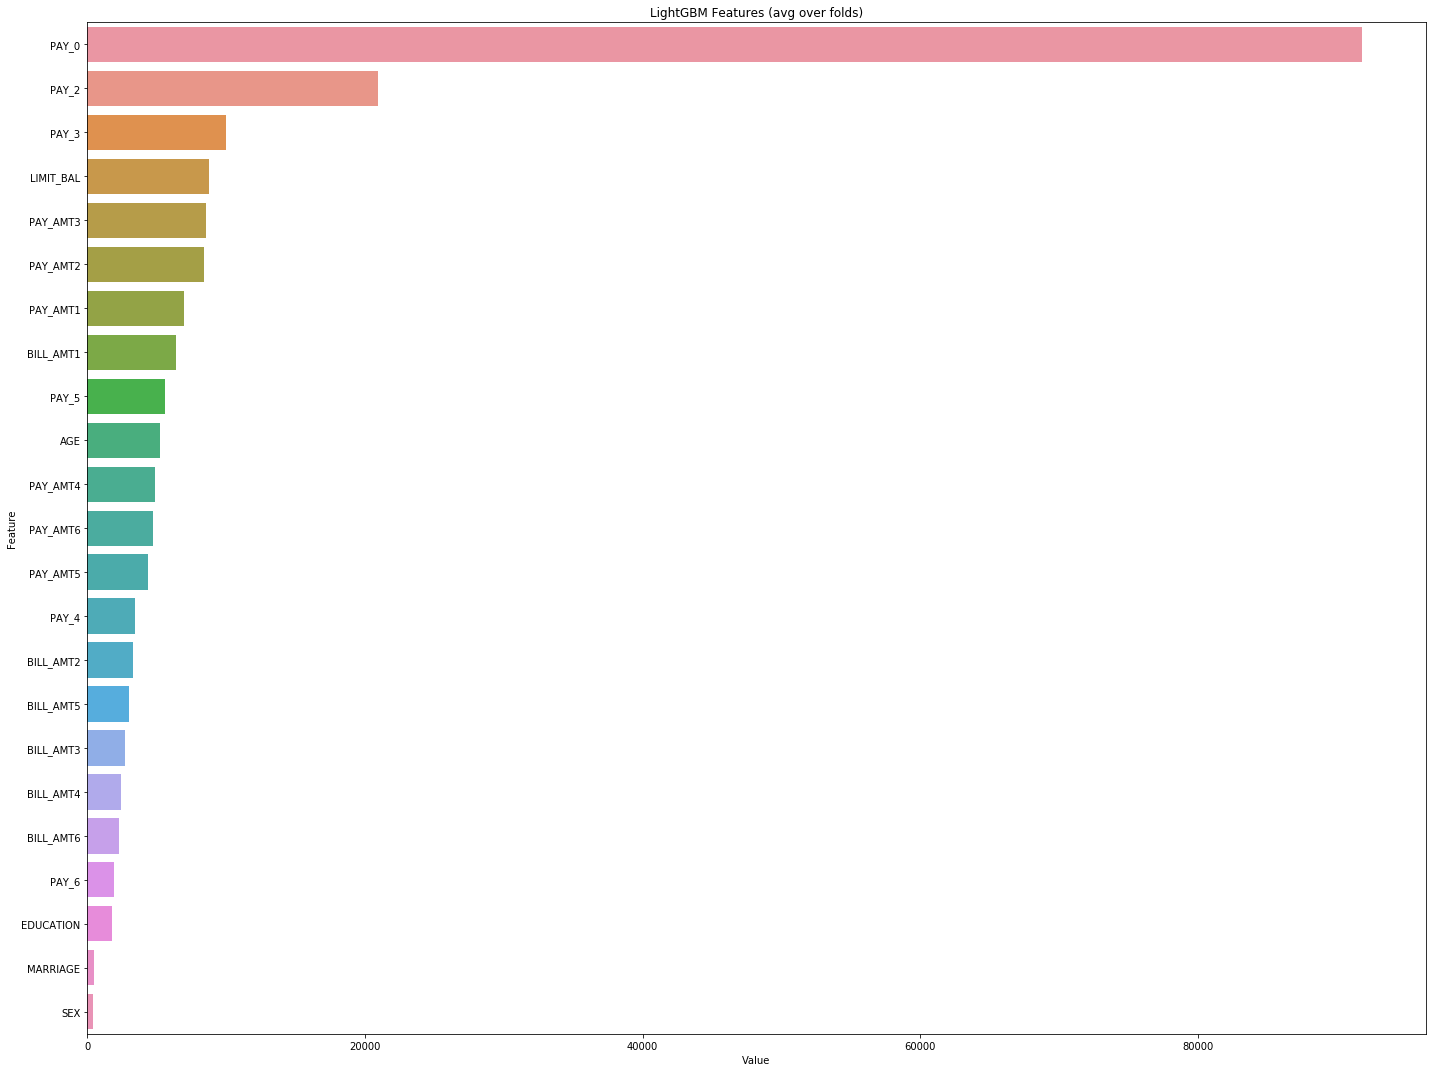

In [10]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [11]:
sub = pd.read_csv("/home/aakash/janta_hack/sample_submission_janta.csv")
sub['default_payment_next_month'] = pred_test
sub.to_csv('final_janta_9.csv',index=False)